In [1]:
import torch
from torch import nn

from torchvision import transforms as T
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
def show_image_tensors(image_tensors, n_images=25, size=(1, 28, 28)):

  image_unflat = image_tensors.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:n_images], nrow=5)

  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

### Creating Generator

In [3]:
def get_generator_block(input_dim, output_dim):
  return nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.BatchNorm1d(output_dim),
      nn.ReLU(inplace=True)
  )

In [4]:
class Generator(nn.Module):

  def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        get_generator_block(z_dim, hidden_dim),
        get_generator_block(hidden_dim, hidden_dim * 2),
        get_generator_block(hidden_dim * 2, hidden_dim * 4),
        get_generator_block(hidden_dim * 4, hidden_dim * 8),
        nn.Linear(hidden_dim * 8, im_dim),
        nn.Sigmoid()
    )

  def forward(self, noise):
    return self.gen(noise)

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
  return torch.randn(n_samples, z_dim, device=device)

### Creating Discriminator

In [6]:
def get_discriminator_block(input_dim, output_dim):
  return nn.Sequential(
      nn.Linear(input_dim, output_dim),
      nn.LeakyReLU(0.2, inplace=True)
  )

In [7]:
class Discriminator(nn.Module):

  def __init__(self, im_dim=784, hidden_dim=128):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        get_discriminator_block(im_dim, hidden_dim * 4),
        get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
        get_discriminator_block(hidden_dim * 2, hidden_dim),
        nn.Linear(hidden_dim , 1)
    )

  def forward(self, image):
    return self.disc(image)

### Training

In [8]:
loss_fn = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 10000
batch_size = 128
lr = 1e-5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
dataloader = DataLoader(MNIST('.', download=True, transform=T.ToTensor()),
                        batch_size=batch_size,
                        shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12818277.47it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 338403.78it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3175744.30it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2446452.90it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [10]:
gen = Generator(z_dim).to(device)
optimizer_G = torch.optim.Adam(params=gen.parameters(),
                               lr=lr)

disc = Discriminator().to(device)
optimizer_D = torch.optim.Adam(params=disc.parameters(),
                               lr=lr)

In [11]:
def get_disc_loss(gen, disc, loss_fn, real, n_images, z_dim, device):

  fake_noise = get_noise(n_images, z_dim, device=device)
  fake = gen(fake_noise)

  disc_fake_pred = disc(fake.detach())
  disc_fake_loss = loss_fn(disc_fake_pred, torch.zeros_like(disc_fake_pred))

  disc_real_pred = disc(real)
  disc_real_loss = loss_fn(disc_real_pred, torch.ones_like(disc_real_pred))

  disc_loss = (disc_real_loss + disc_fake_loss) / 2

  return disc_loss

In [12]:
def get_gen_loss(gen, disc, loss_fn, n_images, z_dim, device):

  fake_noise = get_noise(n_images, z_dim, device=device)
  fake = gen(fake_noise)

  disc_fake_pred = disc(fake)
  gen_loss = loss_fn(disc_fake_pred, torch.ones_like(disc_fake_pred))

  return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000 | Generator Loss: 3.19 | Discriminator Loss: 0.12


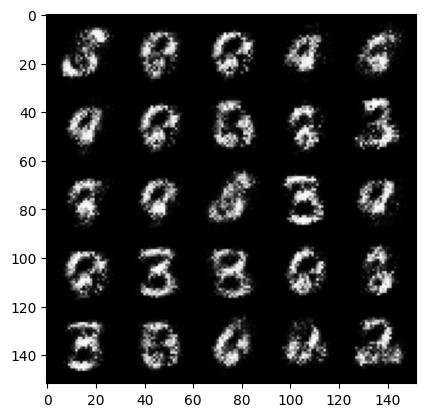

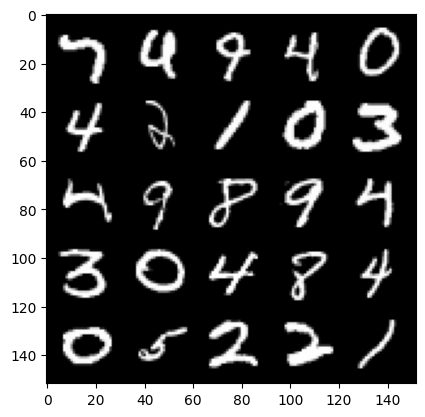

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000 | Generator Loss: 3.95 | Discriminator Loss: 0.10


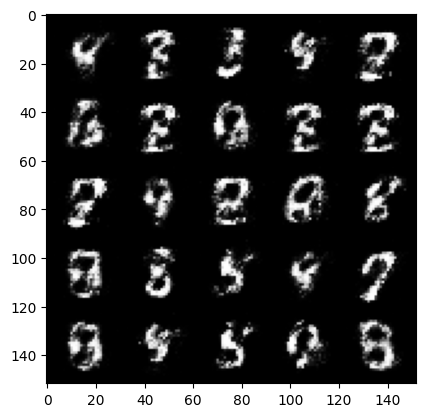

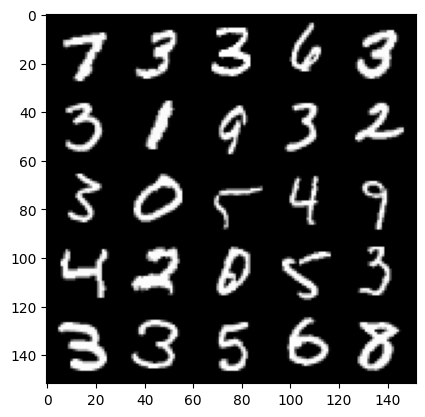

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 30000 | Generator Loss: 3.06 | Discriminator Loss: 0.17


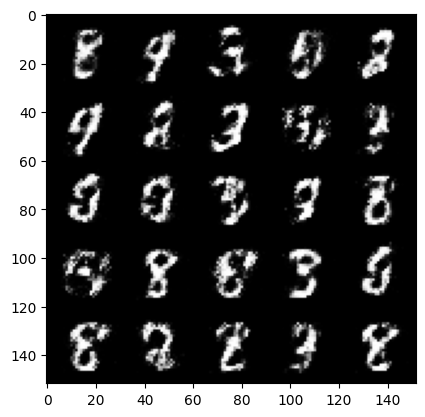

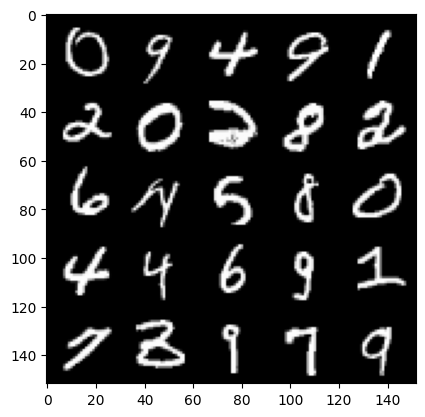

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 40000 | Generator Loss: 2.44 | Discriminator Loss: 0.25


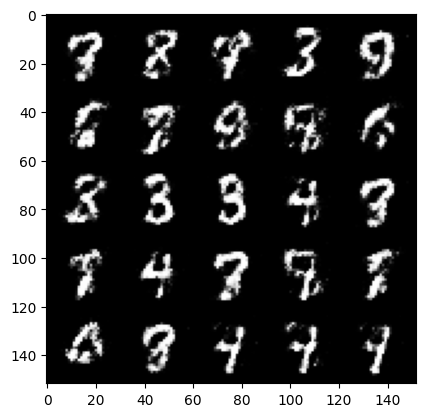

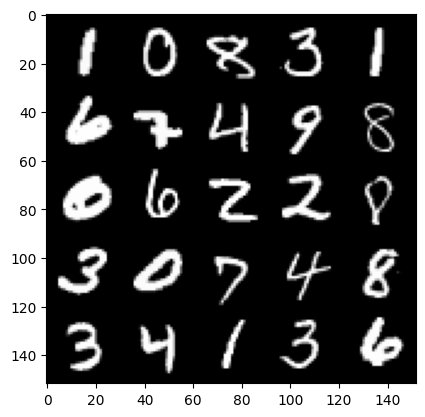

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 50000 | Generator Loss: 2.14 | Discriminator Loss: 0.29


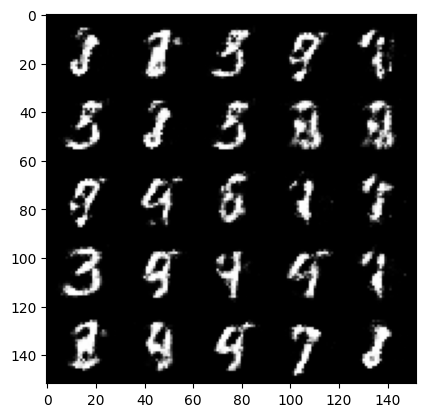

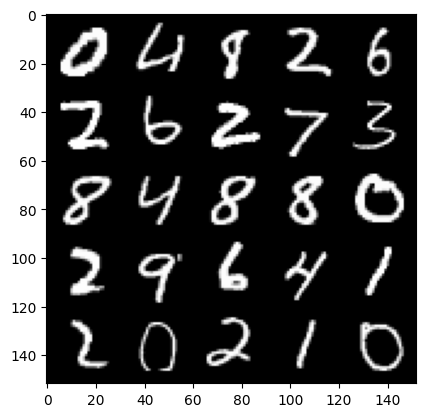

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 60000 | Generator Loss: 1.92 | Discriminator Loss: 0.33


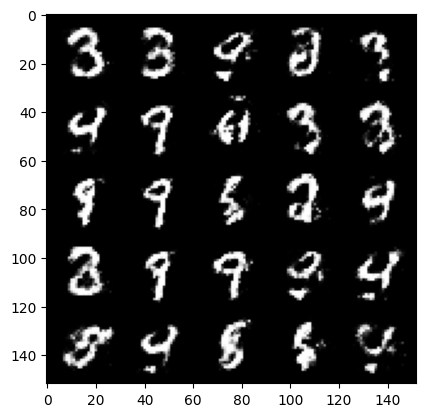

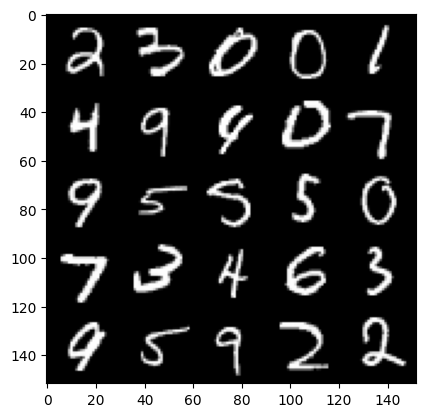

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 70000 | Generator Loss: 1.76 | Discriminator Loss: 0.36


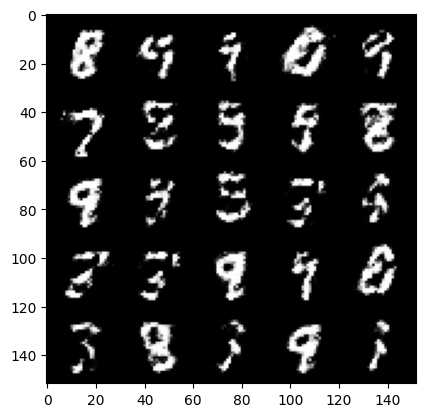

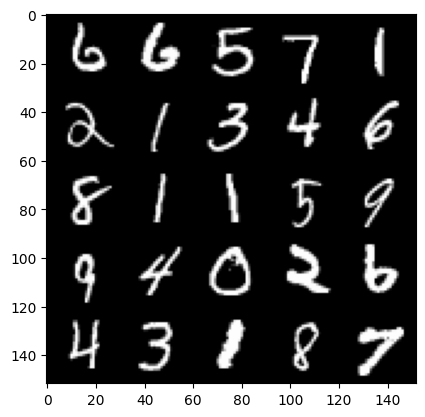

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 80000 | Generator Loss: 1.69 | Discriminator Loss: 0.37


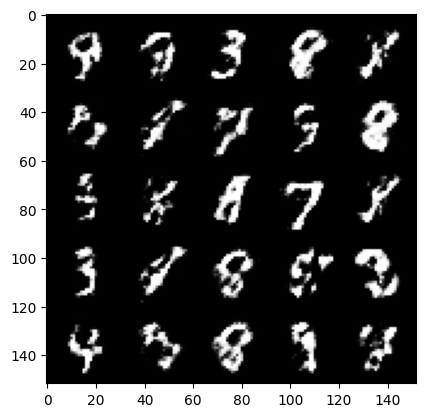

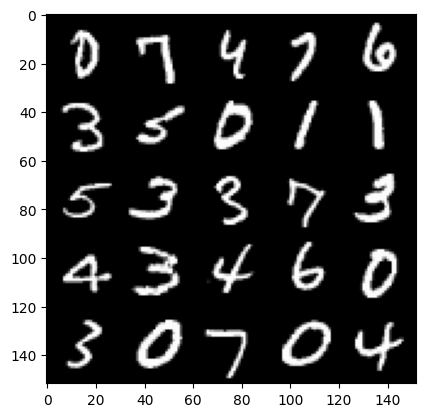

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 90000 | Generator Loss: 1.45 | Discriminator Loss: 0.43


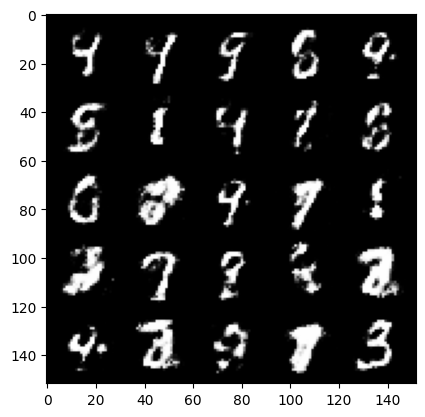

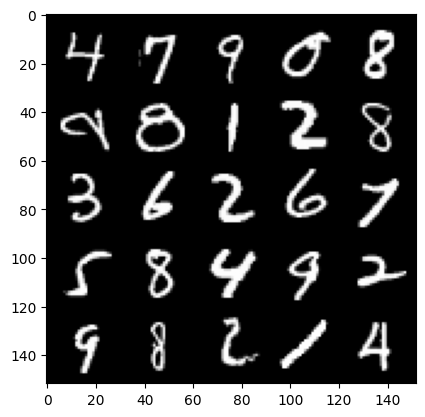

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [13]:
current_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False

for epoch in range(n_epochs):

  for real, _ in tqdm(dataloader):
    current_batch_size = len(real)
    real = real.view(current_batch_size, -1).to(device)

    disc_loss = get_disc_loss(gen=gen,
                              disc=disc,
                              loss_fn=loss_fn,
                              real=real,
                              n_images=current_batch_size,
                              z_dim=z_dim,
                              device=device)
    optimizer_D.zero_grad()
    disc_loss.backward(retain_graph=True)
    optimizer_D.step()

    if test_generator:
      old_generator_weights = gen.gen[0][0].weight.detach().clone()

    gen_loss = get_gen_loss(gen=gen,
                            disc=disc,
                            loss_fn=loss_fn,
                            n_images=current_batch_size,
                            z_dim=z_dim,
                            device=device)
    optimizer_G.zero_grad()
    gen_loss.backward()
    optimizer_G.step()

    if test_generator:
      try:
        assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
        assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
      except:
        error = True
        print('Runtime tests have failed!')

    mean_discriminator_loss += disc_loss.item() / display_step
    mean_generator_loss += gen_loss.item() / display_step
    if current_step % display_step == 0 and current_step > 0:
      print(f'Step {current_step} | Generator Loss: {mean_generator_loss:.2f} | Discriminator Loss: {mean_discriminator_loss:.2f}')

      fake_noise = get_noise(current_batch_size, z_dim, device=device)
      fake = gen(fake_noise)

      show_image_tensors(fake)
      show_image_tensors(real)

      mean_discriminator_loss = 0
      mean_generator_loss = 0

    current_step += 1

In [15]:
torch.save(gen.state_dict(), 'params_gen_nb_2.pth')

In [18]:
torch.save(disc.state_dict(), 'params_disc_nb_2.pth')